In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import seaborn as sns
import yfinance as yf
import math as m
from scipy.stats import norm
import scipy.stats as st

In [52]:
ticker = input("What stock would you like to predict ->").upper()
total = 3 * 365 # total days for histrorical data
trade_days = 252 # number of trading days in a year
n = 10000 # number of simulations

In [53]:
stock = yf.Ticker(ticker)
date_start = dt.date.today() - dt.timedelta(days = total)
data = stock.history(start = date_start)
data = data.drop(columns=['Volume','Dividends','Stock Splits'])


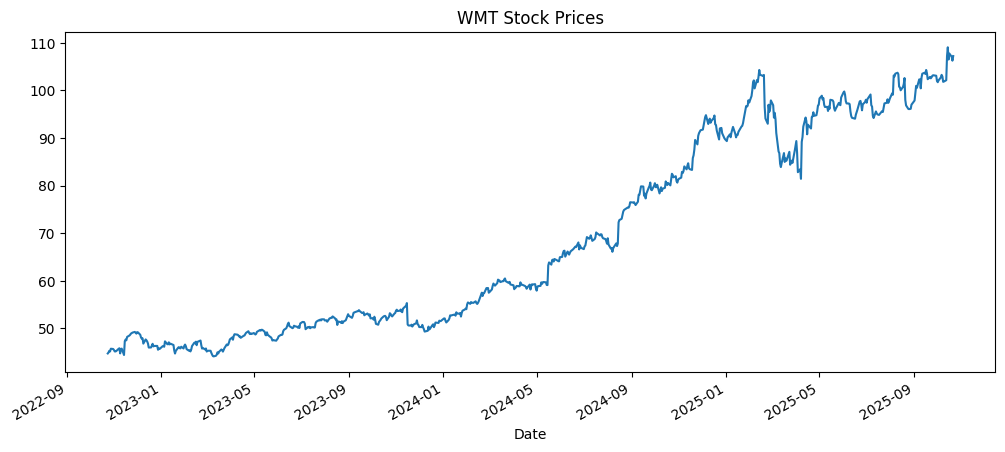

In [54]:
data["Close"].plot(figsize= (12,5))
plt.title(f"{ticker} Stock Prices")
plt.show()

In [55]:
data["Percent Change"] = data["Close"].pct_change() 
data["Log Change"] = np.log(data['Percent Change'] + 1)

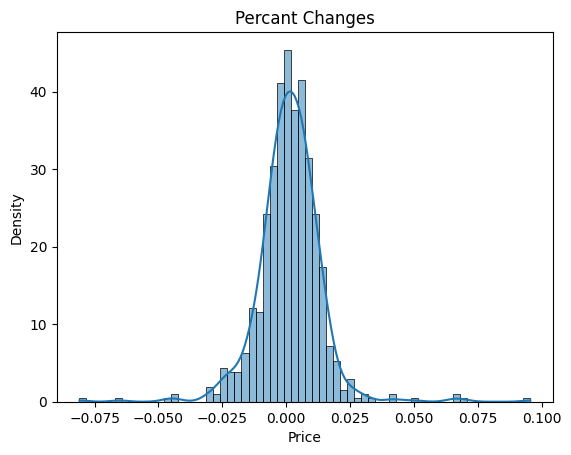

In [56]:
sns.histplot(data["Percent Change"], kde= True, bins='auto', stat='density')
plt.title("Percant Changes")
plt.xlabel("Price")
plt.show()

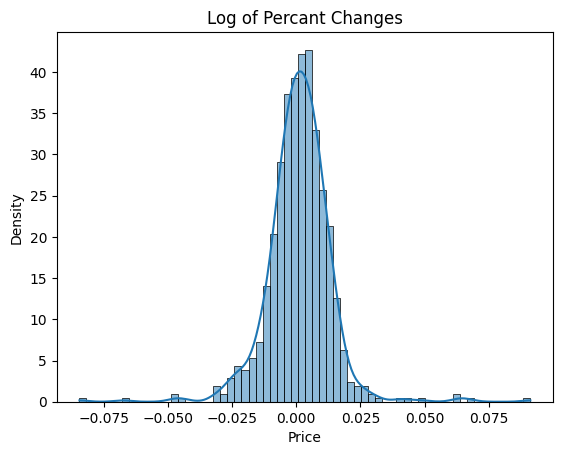

In [57]:
sns.histplot(data["Log Change"], kde= True, bins='auto', stat='density')
plt.title("Log of Percant Changes")
plt.xlabel("Price")
plt.show()

In [58]:
def GBM(data,num = 10000, days = 252, window = total):
    log_change = data["Log Change"][- window : ]
    mu = np.mean(log_change)
    std = np.std(log_change)
    drift = mu - (1/2) * (std**2)

    # X = mu + sigma * Z where Z is N(0,1) gives N(mu,sigma^2)
    #delta_t = 1 as using daily increments and data for drift and volatility are daily closings
    z_updated = np.exp(np.random.normal(loc = drift, scale = std, size = (days,num))) 
    end = np.zeros(shape=(days+1,num))
    end[0] = data['Close'][-1]
    for i in range(1,days+1):
        end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
    return pd.DataFrame(end)

def ProbabilityOver(results,last_close, mu, sigma):
    np.array(results)
    last_close = round(last_close,2)
    print(f"Probabilty over last close ({last_close}) by count: {np.count_nonzero(results > last_close)/len(results)}")
    print(f"Probabilty over last close ({last_close}) by Log Normal: {round(1 - norm.cdf(m.log(last_close), mu, sigma),4)}") #approximation

def VaR_CVaR(results: pd.Series, mu: float, sigma: float, last_close: float, r : float = 10):
    value_r = round(np.percentile(results,r),2)
    value_r_log = round(m.e ** norm.ppf(r/100,mu,sigma),2)
    

    mean_r = round(np.mean([x for x in results if x <= value_r]),2)

    print('\n')
    print(f'Value at which {r}% of predictions fall under by results: {value_r}')
    print(f'Value at which {r}% of predictions fall under by lognormal approximation: {value_r_log}')
    print(f'Expected price of lower {r}%: {mean_r}')
    if mean_r - last_close < 0:
        print(f'Expected loss: {round(abs(mean_r - last_close),2)}') #E[X - last_close] = E[X] - last_close
    else:
        print(f'Expected gain: {round(abs(mean_r - last_close),2)}')
    

In [59]:
sim_df = GBM(data, n, trade_days)
results = np.array(sim_df.iloc[-1])

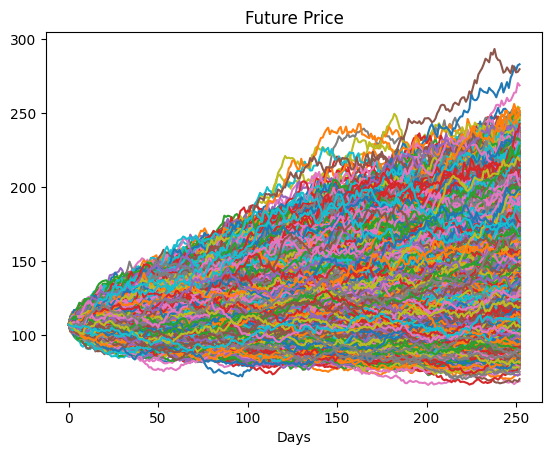

In [60]:
sim_df.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()

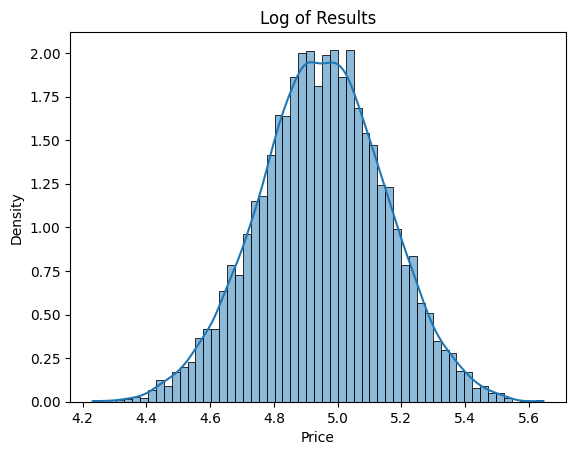

In [61]:
sns.histplot(np.log(results), kde= True, bins='auto', stat='density')
plt.title("Log of Results")
plt.xlabel("Price")
plt.show()

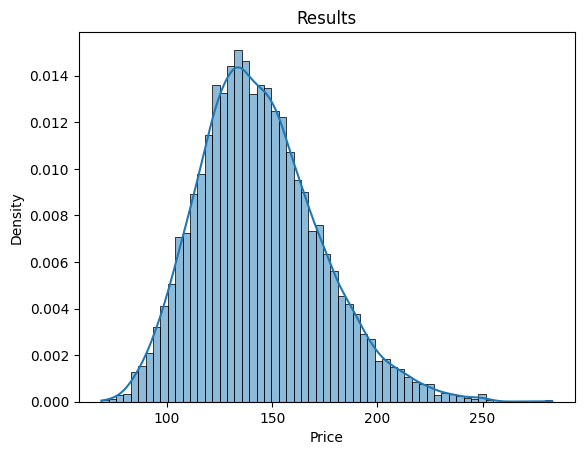

In [62]:
sns.histplot(results, kde= True, bins='auto', stat='density')
plt.title("Results")
plt.xlabel("Price")
plt.show()

In [63]:
expected = np.mean(results)
spread = np.std(results, ddof=1) #1/(n-1) sum(from i = 1 to n) (xi - Xbar)^2. which is used in the approximate pivot for CLT
clt_quant = 1.76
mle_mu = np.mean(np.log(results))
mle_sigma = np.std(np.log(results))

In [64]:
print(f"Price at last close: {round(data['Close'][-1],2)}")
print(f"Expected: {round(expected,2)} Deviation: {round(spread,2)}")
print(f"Median: {round(np.median(results),2)} ; Q1: {round(np.percentile(results,25),2)}  ; Q3 {round(np.percentile(results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print("\n")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(results,5),2)},{round(np.percentile(results,95),2)}]")

clt_upper = round(expected + (spread/(n**(1/2))) * clt_quant , 2) # using (Xbar - mu) / (S/sqrt(n) as an approximate pivot for confidence intervals 
clt_lower = round(expected - (spread/(n**(1/2))) * clt_quant , 2)
print(f"95% Confidence Interval for Real Expected Value of outcome: [{clt_lower},{clt_upper}]")

Price at last close: 107.19
Expected: 144.13 Deviation: 28.79
Median: 141.59 ; Q1: 123.82  ; Q3 161.9 ; IQR: 38.08


90% Confidence Interval for Outcome: [101.47,195.61]
95% Confidence Interval for Real Expected Value of outcome: [143.62,144.64]


In [65]:
ProbabilityOver(results,data["Close"][-1],mle_mu,mle_sigma)
VaR_CVaR(results,mle_mu,mle_sigma,data["Close"][-1], r = 10)

Probabilty over last close (107.19) by count: 0.9141
Probabilty over last close (107.19) by Log Normal: 0.9179


Value at which 10% of predictions fall under by results: 109.18
Value at which 10% of predictions fall under by lognormal approximation: 109.55
Expected price of lower 10%: 99.59
Expected loss: 7.6


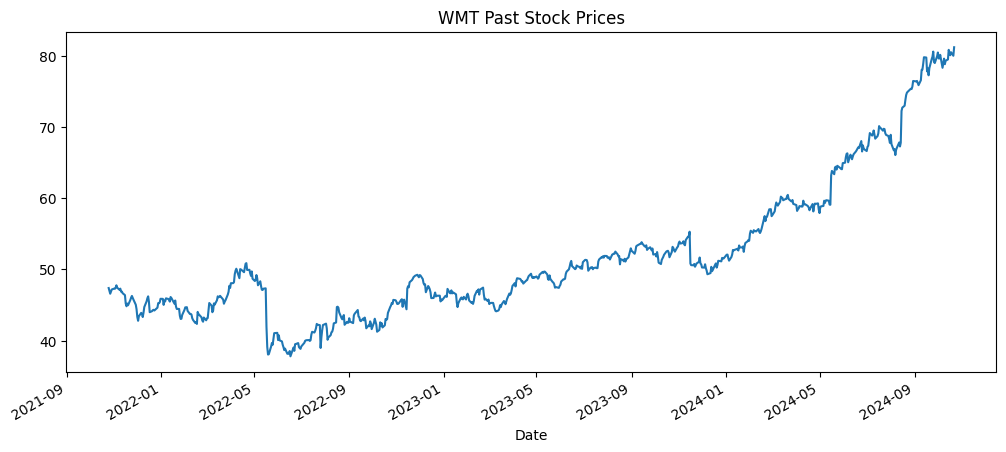

In [66]:
date_start = dt.date.today() - dt.timedelta(days = 365 + total)
new_data = stock.history(start = date_start)
new_data = new_data.drop(columns=['Volume','Dividends','Stock Splits'])

cutoff = pd.Timestamp(dt.date.today() - dt.timedelta(days = 364), tz= 'UTC') #exclusive end of slice
new_data = new_data.loc[:cutoff]
new_data["Percent Change"] = new_data["Close"].pct_change()
new_data["Log Change"] = np.log(new_data['Percent Change'] + 1)

new_data["Close"].plot(figsize= (12,5))

plt.title(f"{ticker} Past Stock Prices")
plt.show()

In [67]:
inclusive_cutoff = new_data.index[-1]
test_sim_df = GBM(new_data, n, len(data.loc[inclusive_cutoff:]['Close'])-1)
test_results = np.array(test_sim_df.iloc[-1]) #lognormal dist
test_expected = np.mean(test_results)
test_spread = np.std(test_results)

print(f"Price at last close: {round(new_data['Close'][-1],2)}")
print(f"Expected: {round(test_expected,2)} Deviation: {round(test_spread,2)}")
print(f"Median: {round(np.median(test_results),2)} ; Q1: {round(np.percentile(test_results,25),2)}  ; Q3 {round(np.percentile(test_results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(test_results,5),2)},{round(np.percentile(test_results,95),2)}]")
print(f"70% Confidence Interval for Outcome: [{round(np.percentile(test_results,15),2)},{round(np.percentile(test_results,85),2)}]")
print(f"Actual Price today: {round(data['Close'][-1],2)}")

Price at last close: 81.23
Expected: 96.85 Deviation: 20.05
Median: 94.81 ; Q1: 82.67  ; Q3 109.18 ; IQR: 38.08
90% Confidence Interval for Outcome: [67.49,132.46]
70% Confidence Interval for Outcome: [76.75,117.4]
Actual Price today: 107.19


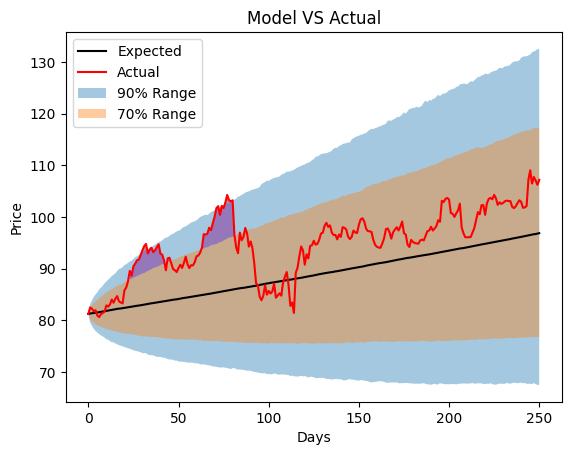

In [68]:
means = []
upper_90 = []
lower_90 = []
upper_70 = []
lower_70 = []

for i in range(len(test_sim_df.index)):
    means.append(np.mean(test_sim_df.iloc[i]))
    upper_90.append(np.percentile(test_sim_df.iloc[i],95))
    lower_90.append(np.percentile(test_sim_df.iloc[i],5))
    upper_70.append(np.percentile(test_sim_df.iloc[i],85))
    lower_70.append(np.percentile(test_sim_df.iloc[i],15))


fig, ax = plt.subplots()
ax.plot(range(len(means)),means, label = 'Expected', color = 'black')
ax.plot(range(len(means)),data.loc[inclusive_cutoff:]["Close"],label = 'Actual', color = 'red')

ax.fill_between(x = range(len(means)), y1=upper_90, y2=lower_90, alpha = .4, label = '90% Range')
ax.fill_between(range(len(means)), upper_90, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] > upper_90, fc='orange', alpha=0.4)
ax.fill_between(range(len(means)), lower_90, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] < lower_90, fc='orange', alpha=0.4)

ax.fill_between(x = range(len(means)), y1=upper_70, y2=lower_70, alpha = .4, label = '70% Range')
ax.fill_between(range(len(means)), upper_70, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] > upper_70, fc='purple', alpha=0.4)
ax.fill_between(range(len(means)), lower_70, data.loc[inclusive_cutoff:]["Close"], where= data.loc[inclusive_cutoff:]["Close"] < lower_70, fc='purple', alpha=0.4)

ax.set_title("Model VS Actual")
ax.set_xlabel("Days")
ax.set_ylabel("Price")
ax.legend(loc = 'upper left')
plt.show()

In [69]:
def get_jumps(log_changes):
    return [i for i in log_changes if abs(i - np.mean(log_changes)) > 3 * np.std(log_changes)]

def GBM_Jump(data,num,days, window = total):
    #There is the possibilty of 0 jumps in a certain window / if only one jump in period, all jumps will be of that size in model
    log_change = data["Log Change"][- window : ]
    jumps = get_jumps(log_change)
    print(f"There were {len(jumps)} jump(s) in the last {window} days.")

    mu = np.mean(log_change)
    std = np.std(log_change)
    

    if len(jumps) > 0:
        jump_mu = np.mean(jumps)
        jump_std = np.std(jumps)
    
        
        k = (m.e ** (jump_mu + (1/2) * jump_std ** 2)) - 1
        lam = len(jumps) / window

        drift = mu - (1/2) * (std ** 2) - lam * k

        # X = mu + sigma * Z where Z is N(0,1) gives N(mu,sigma^2)
        #delta_t = 1 as using daily increments and data for drift and volatility are daily closings
        z = np.random.normal(loc = drift, scale = std, size = (days,num))
        num_jumps = np.random.poisson(lam = lam , size= (days,num))
        jump_size = np.random.normal(loc = jump_mu, scale = jump_std, size=(days,num))
        jump_for_day = num_jumps * jump_size

        #to complete iteratively
        # for i in range(days):
        #     for j in range(num):
        #         z[i][j] = z[i][j] + np.sum(np.random.normal(loc = jump_mu, scale = jump_std, size = num_jumps[i][j]))
    
        z_updated = np.exp(z + jump_for_day)
        end = np.zeros(shape=(days+1,num))
        end[0] = data['Close'][-1]
        for i in range(1,days+1):
            end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
        return pd.DataFrame(end)
    elif len(jumps) == 0: #normal GBM if no jumps in given window
        drift = mu - (1/2) * (std ** 2)
        z_updated = np.exp(np.random.normal(loc = drift, scale = std, size = (days,num))) 
        end = np.zeros(shape=(days+1,num))
        end[0] = data['Close'][-1]
        for i in range(1,days+1):
            end[i] = end[i-1] * z_updated[i-1] #Multiplying lognormal by lognormal produces lognormal
    
        return pd.DataFrame(end)

In [70]:
jump_sim_df = GBM_Jump(data, n, trade_days)
jump_results = np.array(jump_sim_df.iloc[-1]) #lognormal dist
jump_expected = np.mean(jump_results)
jump_spread = np.std(jump_results, ddof=1)

jump_mle_mu = np.mean(np.log(jump_results))
jump_mle_sigma = np.std(np.log(jump_results)) 

There were 12 jump(s) in the last 1095 days.


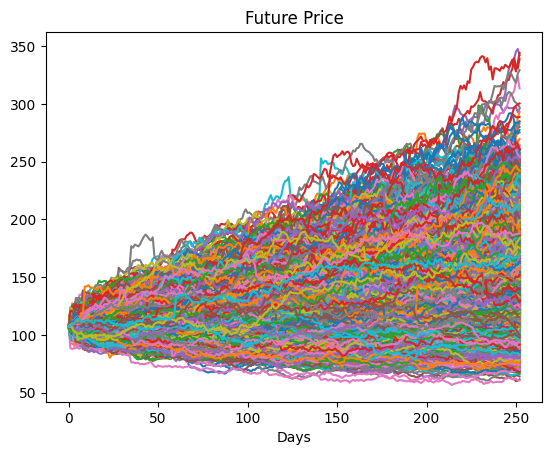

In [71]:
jump_sim_df.plot(legend=False)
plt.title("Future Price")
plt.xlabel("Days")
plt.show()

In [72]:
print(f"Price at last close: {round(data['Close'][-1],2)}")
print(f"Expected: {round(jump_expected,2)} Deviation: {round(jump_spread,2)}")
print(f"Median: {round(np.median(jump_results),2)} ; Q1: {round(np.percentile(jump_results,25),2)}  ; Q3 {round(np.percentile(jump_results,75),2)} ; IQR: {round(np.percentile(jump_results,75) - np.percentile(jump_results,25),2)}")
print("\n"*2)
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(jump_results,5),2)},{round(np.percentile(jump_results,95),2)}]")

jump_clt_upper = round(jump_expected + (jump_spread/(n**(1/2))) * clt_quant , 2) # using (Xbar - mu) / (S/sqrt(n) as an approximate pivot for confidence intervals 
jump_clt_lower = round(jump_expected - (jump_spread/(n**(1/2))) * clt_quant , 2)
print(f"95% Confidence Interval for Real Mean: [{jump_clt_lower},{jump_clt_upper}]")
VaR_CVaR(jump_results,jump_mle_mu,jump_mle_sigma,data["Close"][-1], r = 10)

Price at last close: 107.19
Expected: 143.29 Deviation: 32.51
Median: 139.19 ; Q1: 120.11  ; Q3 162.0 ; IQR: 41.89



90% Confidence Interval for Outcome: [97.51,203.19]
95% Confidence Interval for Real Mean: [142.72,143.86]


Value at which 10% of predictions fall under by results: 105.53
Value at which 10% of predictions fall under by lognormal approximation: 105.1
Expected price of lower 10%: 95.58
Expected loss: 11.61


In [73]:
print("Statistics for GBM:")
print(f"Expected: {round(expected,2)} Deviation: {round(spread,2)}")
print(f"Median: {round(np.median(results),2)} ; Q1: {round(np.percentile(results,25),2)}  ; Q3 {round(np.percentile(results,75),2)} ; IQR: {round(np.percentile(results,75) - np.percentile(results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(results,5),2)},{round(np.percentile(results,95),2)}]")
print(f"Kurtosis: {st.kurtosis(results)}")

print("\nStatistics for Jump Diffusion")
print(f"Expected: {round(jump_expected,2)} Deviation: {round(jump_spread,2)}")
print(f"Median: {round(np.median(jump_results),2)} ; Q1: {round(np.percentile(jump_results,25),2)}  ; Q3 {round(np.percentile(jump_results,75),2)} ; IQR: {round(np.percentile(jump_results,75) - np.percentile(jump_results,25),2)}")
print(f"90% Confidence Interval for Outcome: [{round(np.percentile(jump_results,5),2)},{round(np.percentile(jump_results,95),2)}]")
print(f"Kurtosis: {st.kurtosis(jump_results)}")

Statistics for GBM:
Expected: 144.13 Deviation: 28.79
Median: 141.59 ; Q1: 123.82  ; Q3 161.9 ; IQR: 38.08
90% Confidence Interval for Outcome: [101.47,195.61]
Kurtosis: 0.36422465322486053

Statistics for Jump Diffusion
Expected: 143.29 Deviation: 32.51
Median: 139.19 ; Q1: 120.11  ; Q3 162.0 ; IQR: 41.89
90% Confidence Interval for Outcome: [97.51,203.19]
Kurtosis: 1.1723032212504574


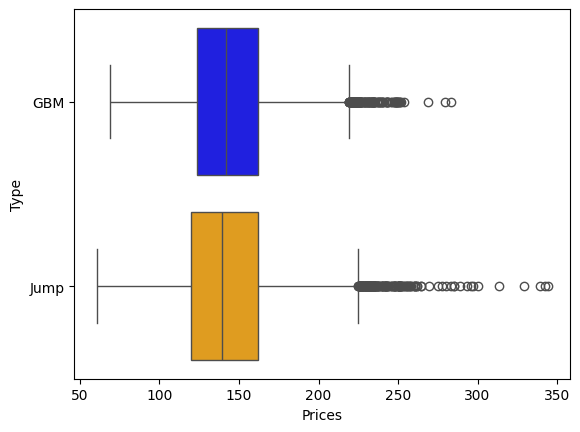

In [74]:
df = pd.concat([pd.DataFrame({"Prices" : results, "Type": ['GBM' for _ in range(len(results))]}), pd.DataFrame({"Prices" : jump_results, "Type": ['Jump' for _ in range(len(results))]})])
bxplt = sns.boxplot(data = df , x = 'Prices', y = 'Type', hue = 'Type', palette = ['b','orange'],legend = False)
plt.show()

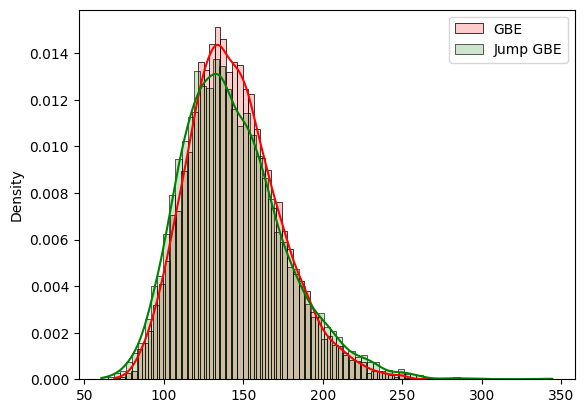

In [75]:
sns.histplot(data= results, color = 'Red', alpha = .2, kde=True, label ='GBE', stat= 'density')
sns.histplot(data= jump_results, color = 'Green', alpha = .2, kde=True, label ='Jump GBE', stat= 'density')

plt.legend()
plt.show()